# MDI230 : Modèle épidémiologique 

Mona Mokart, Lola Vitrac et Zakary Saheb

## 1. Modélisation

Le but de ce projet est de modéliser l'évolution d'une épidémie. Tout au long du projet, on définit par : 

*   $N$ la taille de la population, qui est **fixe**
*   $S(t)$ le nombre d'individus sains 
(et donc susceptibles d'être infectés) à l'instant $t$ 
*   $I(t)$ le nombre d'individus infectés à l'instant $t$
*   $R(t)$ le nombre d'individus retirés (guéris ou morts) à l'instant $t$. **Ces individus ne peuvent plus être contaminés**.
*   $s(t)$, $i(t)$ et $r(t)$ les pourcentages d'individus sains, infectés et retirés à l'instant t 
*   $\gamma$ le temps moyen d'infection
*   $\beta$ le nombre de rencontres par jour (en considérant que **chaque rencontre entre individu sain et individu malade est infectante**) 
*   $R_0$ le coefficient égal au nombre moyen de personnes contaminées par jour en moyenne. On a $R_0=\frac{\beta}{\gamma}$.


## 2. Système déterministe SIR

 On souhaite résoudre et afficher le système déterministe SIR, prenant en entrée les paramètres $\beta$ et $\gamma$. Dans ce modèle, on réfléchit en termes de pourcentages de malades, de susceptibles et de retirés (soit $s(t)$, $i(t)$ et $r(t)$ comme nous l'avons dit précédemment). 

On a donc $s(t)+i(t)+r(t)=1$. L'évolution de ces pourcentages dépendent des paramètres du modèle, on a : 

*  $\frac{di(t)}{dt}=-\gamma i(t) + \beta i(t) s(t)$
*  $\frac{ds(t)}{dt} =-\beta i(t)s(t)$
*  $\frac{dr(t)}{dt} = \gamma i(t)$

A partir de ces équations différentielles, on peut implémenter le modèle de la manière suivante : 

In [ ]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

gamma = 1/28 #duree d'infection à 28 jours
beta = 0.5 #en moyenne 0.5 nouvelles personnes par jour

In [ ]:
# Définition des conditions initiales
i0 = 0.00001
s0 = 1-i0  # pour être à lechelle d'une ville (population de 100 000 habitants)
r0 = 0

# Définition du système d'équation différentielle
def systeme(t, Y, gamma, beta):
    i = Y[0]
    s = Y[1]
    r = Y[2]

    di_dt = -gamma*i +beta*i*s
    ds_dt = -beta*i*s
    dr_dt = gamma*i

    return [di_dt, ds_dt, dr_dt]

# Résolution
solution = solve_ivp(systeme, [0, 200], [i0, s0, r0], method='RK45', args=(
    gamma, beta), max_step=0.01)

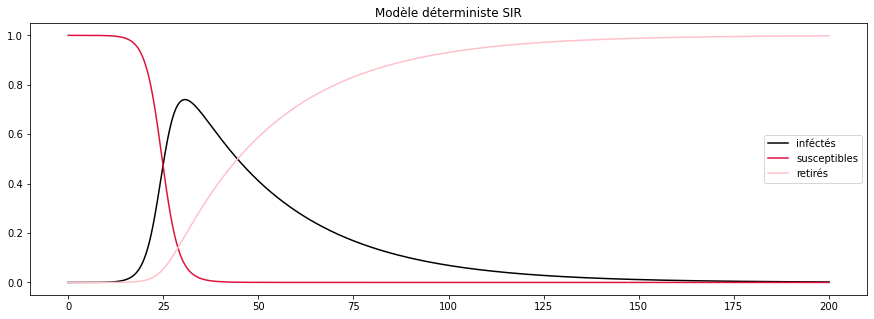

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(solution.t, solution.y[0], label="inféctés", color="k")
plt.plot(solution.t, solution.y[1], label="susceptibles", color="crimson")
plt.plot(solution.t, solution.y[2], label = "retirés", color="pink")
plt.legend()
plt.title("Modèle déterministe SIR")
plt.show()


## 3. Evolution du processus de Markov

On souhaite simuler l'évolution du processus de Markov pour une population de $N$ individus avec les mêmes paramètres $\beta$ et $\gamma$. Afin d'avoir un nombre cohérent d'individus total par rapport à la partie précédente, on prend $N = \frac{1}{i_0}-1$, avec $i_0$ le pourcentage initial d'individus infectés définit dans la partie précédente.

Dans ce modèle, on considère que le triplet $(S(t), I(t), R(t))$ est un processus de Markow, à valeur dans $\{ (S,I,R), S+I+R=N+1 \}$. 

La durée d'infection suit une loi $exp(\gamma)$, et chaque individu rencontre d'autres individus selon un processus de Poisson d'intensité $\beta$. 

Finalement, les individus : 
*   guérissent selon un taux $i \gamma$
*   deviennent malades selon un taux $i \beta$

On peut maintenant implémenter et tracer l'évolution de ce processus de Markow :


In [ ]:
def markov(I0, S0, R0,t,gamma,beta): 
  Stab,Itab,Rtab=[S0],[I0],[R0]
  N = S0
  S,I,R=S0,I0,R0
  times=[0]
  time=np.random.exponential(1/(I*gamma+beta*I*S/N))

  while time < t and I!=0 :
    r = np.random.rand()
    taux = I*gamma/(I*gamma+beta*I*S/N+1e-10)

    if taux > r : #si cette condition est vérifiée, alors l'individu est guéri
      Stab.append(S)
      Itab.append(I-1)
      Rtab.append(R+1)
      I=I-1
      R=R+1

    else : #sinon une personne est infectée
      Stab.append(S-1)
      Itab.append(I+1)
      Rtab.append(R)
      S=S-1
      I=I+1

    times.append(time)
    time += np.random.exponential(1/(I*gamma+beta*I*S/N+1e-10))

  return(times,Stab,Itab,Rtab)
  

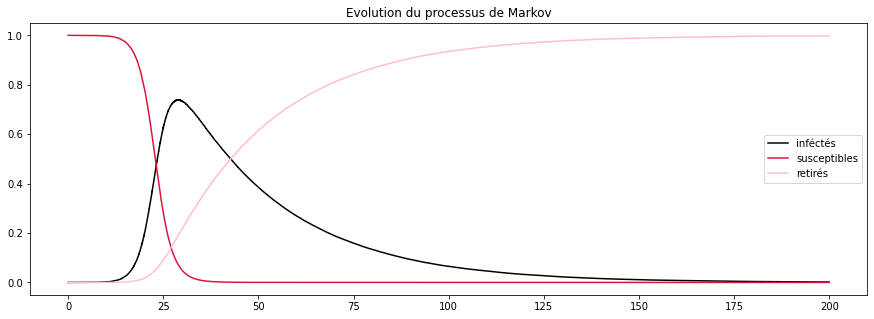

In [ ]:
# Définition des conditions initiales
N=int(1/i0)-1
I0 = 1
S0 = N
R0 = 0
gamma = 1/28 #duree d'infection à 28 jours
beta = 0.5 #en moyenne 0.5 nouvelles personnes par jour

times,S,I,R = markov(I0,S0,R0,200,gamma,beta)

#affichage des résultats 
fig = plt.figure(figsize=(15,5))
plt.plot(times, np.array(I)/(N+1), label="inféctés", color="k")
plt.plot(times, np.array(S)/(N+1), label="susceptibles", color="crimson")
plt.plot(times, np.array(R)/(N+1), label = "retirés", color="pink")
plt.title("Evolution du processus de Markov")
plt.legend()
plt.show()

On remarque que pour des mêmes paramètres d'entrée $\beta$ et $\gamma$, ainsi que pour des mêmes conditions initiales, l'évolution du processus de Markov est quasiment identique à celle du modèle SIR.

## 4. Recherche des couples de valeurs $(\beta,\gamma)$ 

Notre but est de trouver des couples de valeurs $(\beta,\gamma)$ où
*   Tout le monde est retiré sur le long terme (365 jours pour une année)
*   Il y a une partie de la population qui reste susceptible et une autre qui est retirée

Testons le modèle déterministe pour plusieurs couples ($\beta, \gamma)$ : 

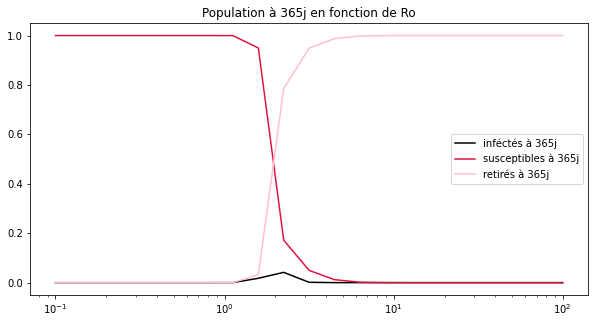

In [ ]:
Ro_list = np.logspace(-1, 2, 21)
gamma2 = 1/28  # On ne change pas la maladie, le temps d'infection reste à 28j
i_list = []
s_list = []
r_list = []
beta2 = Ro_list*gamma

for i in range(len(beta2)):
  solution = solve_ivp(systeme, [0, 365], [i0, s0, r0], method='RK45', args=(
    gamma2, beta2[i]), max_step=0.01)
  i_list.append(solution.y[0][-1])
  s_list.append(solution.y[1][-1])
  r_list.append(solution.y[2][-1])

fig = plt.figure(figsize=(10,5))
plt.plot(Ro_list, i_list, label="inféctés à 365j", color="k")
plt.plot(Ro_list, s_list, label="susceptibles à 365j", color="crimson")
plt.plot(Ro_list, r_list, label = "retirés à 365j", color="pink")
plt.title("Population à 365j en fonction de Ro")
plt.xscale("log")
plt.legend()
plt.show() 

Pour la même maladie (même temps d'infection), on remarque que :
- pour $R_0 < 1 ~ (\beta <\gamma)$  , il y a $\approx$100% de susceptible et $\approx$0% de retirés : la maladie n'est pas assez exposée (peu de contact entre les gens) pour que cela contamine toute la population.
- Pour $R_0$ entre 1 et 10 $(1< \beta <10\gamma)$ le taux de suscpetible baisse et celui des retirés augmentent, il y a donc une partie de la population qui est susceptible et une autre partie qui est retirée .
- Pour $R_0>10 ~ (\beta>10\gamma)$ il n'y a que des retirés et aucun suceptible, donc la maladie a entièrement contaminé la population qui a guéri par la suite.

## 5. Illustration de la convergence du processus de Markov 

Dans cette partie, il s'agit d'illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe

0
1
2
3
4
5
6
7


<Figure size 432x288 with 0 Axes>

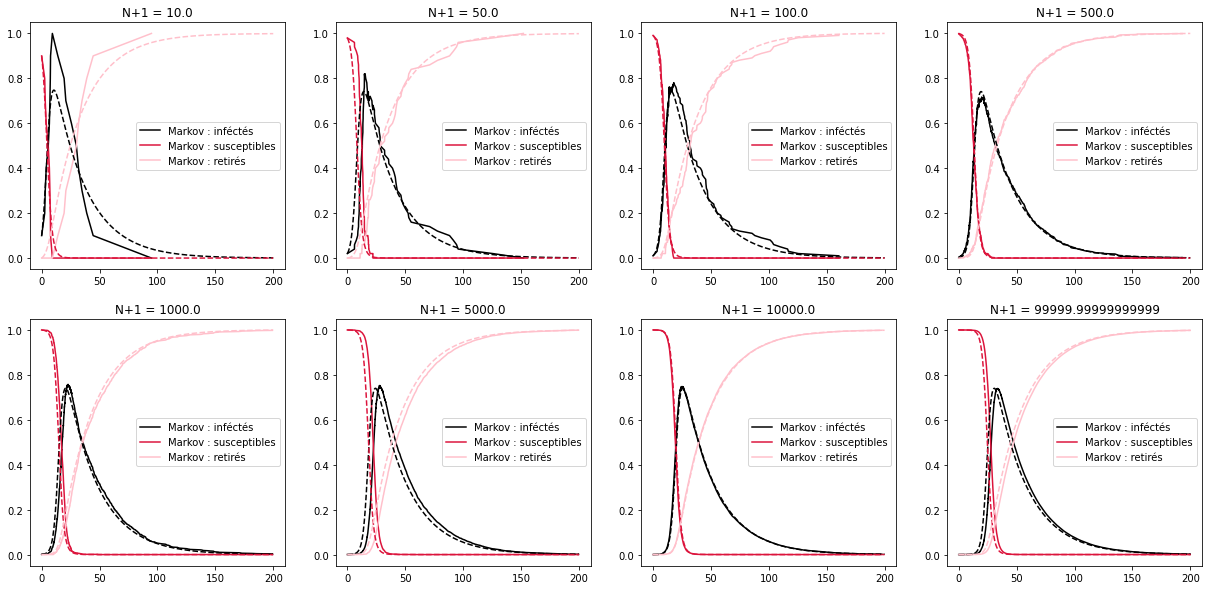

In [ ]:
gamma = 1/28
beta = 0.5


i0_list=np.array([0.1, 0.02, 0.01, 0.002, 0.001, 0.0002, 0.0001, 0.00001])
s0_list = 1-i0_list
r0 = 0

I0 = 1
S0_list = 1/i0_list - 1 
R0 = 0 
mse = np.zeros(5)
fig=plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(21,10))
axes = axes.ravel()

for i in range(len(i0_list)):
  print(i)
  solution = solve_ivp(systeme, [0, 200], [i0_list[i], s0_list[i], r0], method='RK45', args=(
    gamma, beta), max_step=0.01)
  times,S,I,R = markov(I0, S0_list[i], R0, 200, gamma, beta)


  
  axes[i].plot(times, np.array(I)/(S0_list[i]+1), label="Markov : inféctés", color="k")
  axes[i].plot(times, np.array(S)/(S0_list[i]+1), label="Markov : susceptibles", color="crimson")
  axes[i].plot(times, np.array(R)/(S0_list[i]+1), label = "Markov : retirés", color="pink")

    
  axes[i].plot(solution.t, solution.y[0], color="k", ls='--')
  axes[i].plot(solution.t, solution.y[1], color="crimson", ls='--')
  axes[i].plot(solution.t, solution.y[2], color="pink", ls='--')
  axes[i].legend()
  axes[i].set_title("N+1 = " +str(1/i0_list[i]))
plt.show()

Le modèle du processus de Markov converge vers le modèle déterministe à partir d'une population de 1000 personnes

## 6. Question Ouverte

Tentons d'effectuer des simulations pour trouver les meilleurs paramètres $\gamma$ et $\beta$ dans le cadre d'une modélisation de la pandémie du covid 19. Une modélisation SIR ou de Markov ne prends pas en compte l'influence potentielle des différents confinements et couvre-feu, ou d'autres mesures gouvernementales ayant pu impacter l'évolution "normale" de la pandémie. Nous utilisons les données disponibles sur [ce lien](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19).

Nous nous plaçons dans le département de Paris (75) pour effectuer cette modélisation et essayons déjà d'ajuster les paramètres en fonction de ce que nous savons du virus (durée d'infection, nombre de nouvelles infections par jour...). 

Utilisons la méthode présentée dans [cet article]( https://hal.archives-ouvertes.fr/hal-02923715/document) pour estimer les meilleurs paramètres, se basant sur une estimation graphique et précise. Nous pouvons également imaginer une méthode d'apprentissage de machine learning ou de deep learning visant à optimiser les paramètres de manière à minimiser une fonction de cout mesurant la différence entre la modélisation et la réalité.

In [ ]:
#Import de la base de données

import pandas as pd

df = pd.read_csv('/content/donnees-hospitalieres-nouveaux-covid19-2021-06-26-21h05.csv', sep=';')

In [ ]:
df_75 = df.loc[(df['dep']=='75'),:]

In [ ]:
df_75

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
34875,75,2020-03-19,167,41,11,31
34876,75,2020-03-20,120,21,5,28
34877,75,2020-03-21,138,34,7,35
34878,75,2020-03-22,147,31,4,33
34879,75,2020-03-23,189,31,18,33
...,...,...,...,...,...,...
35335,75,2021-06-22,4,1,4,27
35336,75,2021-06-23,10,1,3,26
35337,75,2021-06-24,13,3,2,23
35338,75,2021-06-25,8,2,1,24


On observe dans un premiers temps que les données de la base se compte en incidence d'hospitalisation, de réanimation, de déçès et de retour chez soi. Cela ne correspond pas à la modélisation de pourcentage d'individus sains, retirés et infectés à un instant t.

Il faudrait alors retrouver ce modèle à partir des données que l'on a, en prenant en additionnant l'incidence en hospitalisation et en réanimation pour les infectés, en additionnant les décés et les retours pour les retirés.

Cette modélisation ne nous permet pas de retrouver correctement le modèlee que nous avions fait. De plus, nous pouvons voir apparaitre les différentes vagues. Nous décidons donc de caler le modèle paramétrique SIR sur le début de l'épidemie (sur le nombre d'infectés) en imaginant qu'il n'y ait jamais eu les vagues successives.

In [ ]:
dc_75 = np.array(df_75.incid_dc)
hosp_75 = np.array(df_75.incid_hosp)
rea_75 = np.array(df_75.incid_rea)
rad_75 = np.array(df_75.incid_rad)


Considérons que le nombre d'infectés dans le modèle qui nous est donné correspond au nombre d'hospitalisés et en réanimation. On sait que cela représente une partie infime de la population réellement infectée, mais on peut considérer que cela représente bien le comportement de l'évolution de la pandémie. Nous décidons donc de multiplier par un facteur multiplicatif, prenant en compte toutes ces considérations.

In [ ]:
i = hosp_75+rea_75
r = rad_75+dc_75

In [ ]:
#Simulation 

i1 = 0.000001
s1 = 1-i1  # pour être à lechelle d'une ville (population de 1 000 000 habitants)
r1 = 0

gamma1 = 1/20
beta1 = 3

solution = solve_ivp(systeme, [0, 464], [i1, s1, r1], method='RK45', args=(
    gamma1, beta1), max_step=0.01)

Text(0.5, 1.0, "Incidence d'infectés par jour dans le département 75")

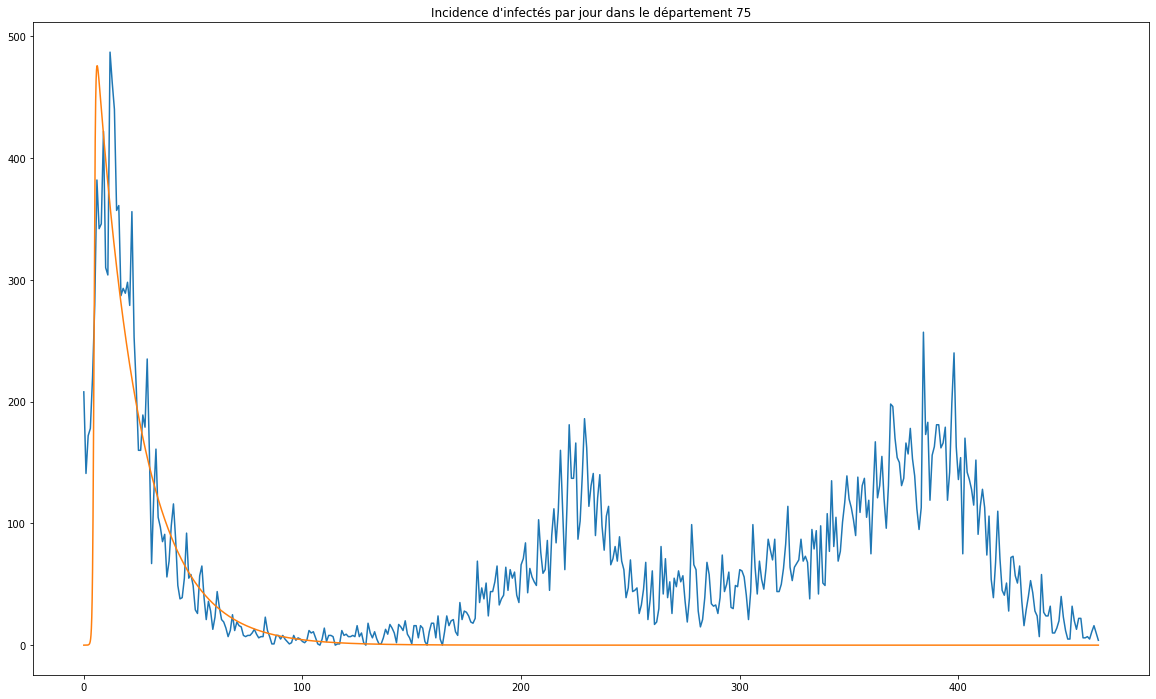

In [ ]:
x = np.linspace(0,464,465)
x_1 = np.linspace(0,464,46402)
plt.figure(figsize=(20, 12))
plt.plot(x,i)
plt.plot(x_1,solution.y[0]*520)
#plt.plot(x,i)
#plt.plot(x,r)
#plt.plot(x,rad_75)

plt.title("Incidence d'infectés par jour dans le département 75")

Avec les hypothèses que nous avons estimées et les simplifications du modèle réel que nous avons faites, nous pouvons observer que grâce à une méthode de recherche graphique comme celle proposée dans l'article, nous arrivons à bien superposer la courbe d'incidence du nombre d'infectés avec la modélisation SIR, avec $\beta = 3$ et $\gamma = 1/20$. 

Cependant, cette modélisation reste éloignée de la réalité car ne prenant pas en compte de nombreux facteurs environnementaux et sociaux, et par le fait que les données disponibles ne rendaient pas parfaitement compte de la situation sanitaire. 